# **Classification of medical images with convolutional networks**

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 7.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=2cf90f04660537b42ae819cc56cf4cd8b07b9bdcf3bd85c85ccb88f9f25576b5
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


## Εισαγωγή αναγκαίων βιβλιοθηκών και πακέτων


In [ ]:
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler

import medmnist
from medmnist import INFO
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import time

print("Pytorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())

Pytorch version: 1.11.0+cu113
GPU available: True
MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


## Transforms


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        #Data Augmentation                         
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #Data Normalization 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

## Colon Pathology dataset 




In [ ]:
path_info = INFO['pathmnist']
path_task = path_info['task']
path_channels = path_info['n_channels']
path_classes = len(path_info['label'])

print ("Dataset images have", path_channels, "channels. The type of problem is", path_task, "classification with ", path_classes, "classes.")

Οι εικόνες του dataset έχoυν 3 κανάλια. Ο τύπος προβλήματος είναι multi-class ταξινόμηση με 9 κλάσεις.


  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
---------------------------------------------------------------------
Διαθέσιμες πληροφορίες για το dataset:
dict_keys(['python_class', 'description', 'url', 'MD5', 'task', 'label', 'n_channels', 'n_samples', 'license'])
Περιγραφή dataset:
The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Ερμηνεία labels:
{'0'

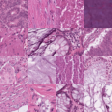

In [ ]:
Path_DataClass = getattr(medmnist, path_info['python_class'])

#load and (download) data
path_train_dataset = Path_DataClass(split='train', transform=data_transforms['train'], download=True)
path_val_dataset = Path_DataClass(split='val', transform=data_transforms['test'], download=True)
path_test_dataset = Path_DataClass(split='test', transform=data_transforms['test'], download=True)

print("---------------------------------------------------------------------")
print("Info for the dataset:")
print(path_train_dataset.info.keys())
print("Dataset description:")
print(path_train_dataset.info['description'])
print("Labels interpretation:")
print(path_train_dataset.info['label'])

BATCH_SIZE = 128

# encapsulate data into dataloader form
path_train_loader = data.DataLoader(dataset=path_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
path_val_loader = data.DataLoader(dataset=path_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
path_test_loader = data.DataLoader(dataset=path_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print("Image sample of the Colon Pathology dataset:")
path_train_dataset.montage(length=4)

## Create model



In [ ]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d

class Net(nn.Module):
  def __init__(self, num_classes):
      super().__init__()

      self.layer1 = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU()
      )

      self.layer2 = nn.Sequential(
          nn.Conv2d(16, 32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU()
      )

      self.layer3 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5, padding=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )

      self.layer4 = nn.Sequential(
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )

      self.layer5 = nn.Sequential(
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )

      self.fc = nn.Sequential(
          nn.Linear(576, 1024),
          nn.ReLU(),
          nn.Linear(1024, num_classes)
      )

  def forward(self, x):
     x = self.layer1(x)
     x = self.layer2(x)
     x = self.layer3(x)
     x = self.layer4(x)
     x = self.layer5(x)
     x = x.view(x.size(0), -1)
     x = self.fc(x)
     return x
     

# Define Optimizer and Loss

In [ ]:
import torch.optim as optim

path_model = Net(num_classes = path_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(path_model.parameters(), lr=0.005, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
epochs = 9

#CUDA activation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Training Code


In [ ]:
def train_loop(model, loss_fn, optimizer, scheduler, num_epochs, dataloader, dataSet):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        running_loss = 0.0
        model.train()
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Backpropagation
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            #statistics
            running_loss += loss.item()
    
        scheduler.step()
        epoch_loss = running_loss / len(dataloader)
        print(f'Training Loss: {epoch_loss:.4f}')

        if dataSet == 'PathMNIST':
          test_loop(model, loss_fn, 'Train', 'PathMNIST')
          test_loop(model, loss_fn, 'Validation', 'PathMNIST')
          print('\n')
        elif dataSet == 'BloodMNIST':
          test_loop(model, loss_fn, 'Train', 'BloodMNIST')
          test_loop(model, loss_fn, 'Validation', 'BloodMNIST')
          print('\n')

    if dataSet == 'PathMNIST':
      test_loop(model, loss_fn, 'Test', 'PathMNIST')
    elif dataSet == 'BloodMNIST':
      test_loop(model, loss_fn, 'Test', 'BloodMNIST')

    print('Finished Training!!')

# Test Code

In [ ]:
def test_loop(model, loss_fn, split, dataSet):
    model.eval()

    if dataSet == 'PathMNIST':
      if split == 'Train':
        dataloader = path_train_loader
      elif split == 'Validation':
        dataloader = path_val_loader
      else:
        dataloader = path_test_loader
    elif dataSet == 'BloodMNIST':
      if split == 'Train':
        dataloader = blood_train_loader
      elif split == 'Validation':
        dataloader = blood_val_loader
      else:
        dataloader = blood_test_loader

    running_accuracy = 0.0

    with torch.no_grad():
      for inputs, targets in dataloader:
          inputs = inputs.to(device) 
          targets = targets.to(device) 

          outputs = model(inputs) 
          targets = targets.squeeze().long()
          outputs = outputs.softmax(dim=1)
          targets = targets.float().resize_(len(targets), 1)

          outputs = outputs.cpu().numpy()
          targets = targets.cpu().numpy()

          #in every batch calculate accuracy and add it to a running accuracy variable
          running_accuracy += accuracy_score(targets, np.argmax(outputs, axis=1))
      
      #accuracy average
      accuracy = running_accuracy / len(dataloader)

    print(f'{split} Accuracy: {accuracy:.4f}')

In [ ]:
path_model = path_model.to(device)
train_loop(path_model, criterion, optimizer, scheduler, epochs, path_train_loader, 'PathMNIST')

Epoch 0/8
----------


100%|██████████| 704/704 [00:31<00:00, 22.66it/s]


Training Loss: 0.5922
Train Accuracy: 0.8007
Validation Accuracy: 0.7991


Epoch 1/8
----------


100%|██████████| 704/704 [00:30<00:00, 23.05it/s]


Training Loss: 0.3070
Train Accuracy: 0.6877
Validation Accuracy: 0.6842


Epoch 2/8
----------


100%|██████████| 704/704 [00:30<00:00, 22.86it/s]


Training Loss: 0.2264
Train Accuracy: 0.9174
Validation Accuracy: 0.9136


Epoch 3/8
----------


100%|██████████| 704/704 [00:30<00:00, 23.19it/s]


Training Loss: 0.1510
Train Accuracy: 0.9455
Validation Accuracy: 0.9437


Epoch 4/8
----------


100%|██████████| 704/704 [00:30<00:00, 22.83it/s]


Training Loss: 0.1362
Train Accuracy: 0.9536
Validation Accuracy: 0.9483


Epoch 5/8
----------


100%|██████████| 704/704 [00:30<00:00, 23.02it/s]


Training Loss: 0.1248
Train Accuracy: 0.9548
Validation Accuracy: 0.9493


Epoch 6/8
----------


100%|██████████| 704/704 [00:30<00:00, 22.92it/s]


Training Loss: 0.0971
Train Accuracy: 0.9703
Validation Accuracy: 0.9623


Epoch 7/8
----------


100%|██████████| 704/704 [00:30<00:00, 22.92it/s]


Training Loss: 0.0910
Train Accuracy: 0.9749
Validation Accuracy: 0.9674


Epoch 8/8
----------


100%|██████████| 704/704 [00:31<00:00, 22.65it/s]


Training Loss: 0.0857
Train Accuracy: 0.9687
Validation Accuracy: 0.9629


Test Accuracy: 0.9629
Finished Training!!


## Blood Cell Microscope dataset 

In [ ]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
print (task)
blood_channels = info['n_channels'] 
blood_classes = len(info['label'])

Blood_Dataclass = getattr(medmnist, info['python_class'])

multi-class


  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'task': 'multi-class', 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '

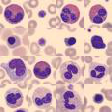

In [ ]:
# load the data
blood_train_dataset = Blood_Dataclass(split='train', transform=data_transforms['train'], download=download)
blood_val_dataset = Blood_Dataclass(split='val', transform=data_transforms['test'], download=download)
blood_test_dataset = Blood_Dataclass(split='test', transform=data_transforms['test'], download=download)
print(blood_test_dataset.info)

# encapsulate data into dataloader form
blood_train_loader = data.DataLoader(dataset=blood_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
blood_val_loader = data.DataLoader(dataset=blood_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
blood_test_loader = data.DataLoader(dataset=blood_test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print("Image sample of the Blood Cell Microscope dataset:")
blood_train_dataset.montage(length=4)

# Training with Transfer Learning in BloodMNIST Dataset

In [ ]:
import copy

#copy of the model 
modelB = copy.deepcopy(path_model.state_dict())

#adjust the fully connected layer to BloodMNIST dataset
modelB.fc = nn.Sequential(
            nn.Linear(576, 1024),
            nn.ReLU(),
            nn.Linear(1024, blood_classes)
          )

#load modelB to path_model
path_model.load_state_dict(modelB)
path_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(path_model.parameters(), lr=0.005, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
epochs = 9

#train the model to BloodMNIST dataset
train_loop(path_model, criterion, optimizer, scheduler, epochs, blood_train_loader, 'BloodMNIST')

Epoch 0/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.31it/s]


Training Loss: 0.6824
Train Accuracy: 0.8682
Validation Accuracy: 0.8659


Epoch 1/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.53it/s]


Training Loss: 0.2926
Train Accuracy: 0.8641
Validation Accuracy: 0.8656


Epoch 2/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.66it/s]


Training Loss: 0.2269
Train Accuracy: 0.9237
Validation Accuracy: 0.9255


Epoch 3/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.85it/s]


Training Loss: 0.2056
Train Accuracy: 0.9300
Validation Accuracy: 0.9267


Epoch 4/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.81it/s]


Training Loss: 0.1696
Train Accuracy: 0.9333
Validation Accuracy: 0.9294


Epoch 5/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.84it/s]


Training Loss: 0.1557
Train Accuracy: 0.9463
Validation Accuracy: 0.9407


Epoch 6/8
----------


100%|██████████| 94/94 [00:04<00:00, 21.90it/s]


Training Loss: 0.1455
Train Accuracy: 0.9498
Validation Accuracy: 0.9438


Epoch 7/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.34it/s]


Training Loss: 0.1423
Train Accuracy: 0.9547
Validation Accuracy: 0.9452


Epoch 8/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.42it/s]


Training Loss: 0.1324
Train Accuracy: 0.9606
Validation Accuracy: 0.9516


Test Accuracy: 0.9439
Finished Training!!


# Training without Transfer Learning in BloodMNIST dataset


In [ ]:
blood_model = Net(num_classes = blood_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(blood_model.parameters(), lr=0.005, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
epochs = 9

blood_model.to(device)
train_loop(blood_model, criterion, optimizer, scheduler, epochs, blood_train_loader, 'BloodMNIST')

Epoch 0/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.28it/s]


Training Loss: 0.7090
Train Accuracy: 0.8589
Validation Accuracy: 0.8589


Epoch 1/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.35it/s]


Training Loss: 0.3095
Train Accuracy: 0.8833
Validation Accuracy: 0.8834


Epoch 2/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.51it/s]


Training Loss: 0.2305
Train Accuracy: 0.9196
Validation Accuracy: 0.9123


Epoch 3/8
----------


100%|██████████| 94/94 [00:04<00:00, 23.10it/s]


Training Loss: 0.1835
Train Accuracy: 0.8836
Validation Accuracy: 0.8836


Epoch 4/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.74it/s]


Training Loss: 0.1517
Train Accuracy: 0.9238
Validation Accuracy: 0.9119


Epoch 5/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.25it/s]


Training Loss: 0.1383
Train Accuracy: 0.9451
Validation Accuracy: 0.9402


Epoch 6/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.60it/s]


Training Loss: 0.1182
Train Accuracy: 0.9646
Validation Accuracy: 0.9492


Epoch 7/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.88it/s]


Training Loss: 0.1150
Train Accuracy: 0.9674
Validation Accuracy: 0.9469


Epoch 8/8
----------


100%|██████████| 94/94 [00:04<00:00, 22.95it/s]


Training Loss: 0.1021
Train Accuracy: 0.9719
Validation Accuracy: 0.9520


Test Accuracy: 0.9557
Finished Training!!
